In [10]:
import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from scipy.stats import gaussian_kde
import seaborn as sns
import re

import importlib
import toylosses
importlib.reload(toylosses)
import toynn
importlib.reload(toynn)
import toyvis
importlib.reload(toyvis)

import torch
sns.set()

DEVICE = 'cuda'
OUTPUT = '/scratch/users/nmiolane/toyoutput'

# Decide on experiment's configuration

layers.0.weight tensor([[2.]], device='cuda:0') 



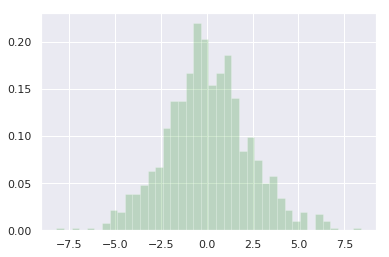

In [11]:
DATA_DIM = 1
LATENT_DIM = 1
N_DECODER_LAYERS = 1
NONLINEARITY = False
N_SAMPLES = 1000
N_IS_SAMPLES = 100000
WITH_BIASX = False
WITH_LOGVARX = False

W_TRUE = {}
B_TRUE = {}

W_TRUE[0] = [[2.]]


if WITH_LOGVARX:
    assert len(W_TRUE) == N_DECODER_LAYERS + 1, len(W_TRUE)
else:
    assert len(W_TRUE) == N_DECODER_LAYERS

WITH_BIASZ = True
WITH_LOGVARZ = True

decoder_true = toynn.make_decoder_true(
    w_true=W_TRUE, b_true=B_TRUE, latent_dim=LATENT_DIM, 
    data_dim=DATA_DIM, n_layers=N_DECODER_LAYERS,
    nonlinearity=NONLINEARITY, with_biasx=WITH_BIASX, with_logvarx=WITH_LOGVARX)

for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')

generated_true_x = toynn.generate_from_decoder(decoder_true, N_SAMPLES)

fig, ax = plt.subplots()
ax = toyvis.plot_data(generated_true_x, color='green', label='from decoder true', ax=ax)

# Inspect generation of synthetic data from decoder_true

layers.0.weight tensor([[2.]], device='cuda:0') 



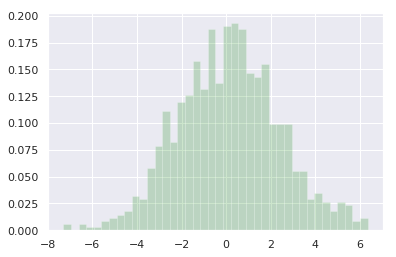

In [12]:
decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)

for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')
    
generated_true_x = toynn.generate_from_decoder(decoder_true, N_SAMPLES)

fig, ax = plt.subplots()
ax = toyvis.plot_data(generated_true_x, color='green', label='from decoder true', ax=ax)

In [13]:
# TODO(nina): Add a comparison to a FA?

# Inspect results from standard VAE

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[0.0231]], device='cuda:0') 



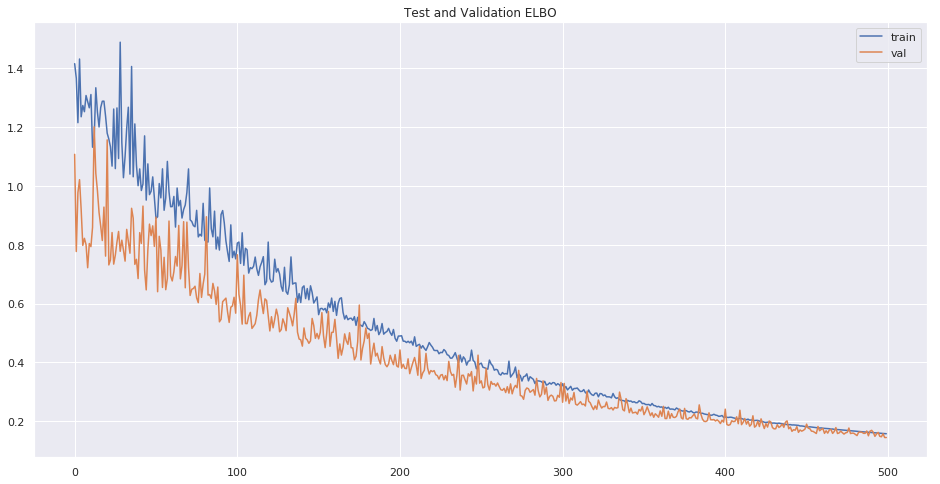

In [14]:
decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)

decoder_path = glob.glob(f'{OUTPUT}/train_vae/models/decoder.pth')[0]
decoder = torch.load(decoder_path, map_location=DEVICE)

print('-- True values of parameters')
for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')

print('\n-- Learnt values of parameters')
for name, param in decoder.named_parameters():
    print(name, param.data, '\n')
    
train_losses_path = glob.glob(f'{OUTPUT}/train_vae/train_losses.pkl')[0]
train_losses_all_epochs = pickle.load(open(train_losses_path, 'rb'))

val_losses_path = glob.glob(f'{OUTPUT}/train_vae/val_losses.pkl')[0]
val_losses_all_epochs = pickle.load(open(val_losses_path, 'rb'))

train_losses_total = [loss['total'] for loss in train_losses_all_epochs]
val_losses_total = [loss['total'] for loss in val_losses_all_epochs]
n_epochs = len(train_losses_total)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

#ax = axes[0]
ax.plot(range(n_epochs), train_losses_total, label='train')
ax.plot(range(n_epochs), val_losses_total, label='val')
ax.set_title('Test and Validation ELBO')
ax.legend()

#ax = axes[1]
#ax.plot(range(90, n_epochs), train_losses_total[90:])

#ax = axes[2]
#ax.plot(range(160, n_epochs), train_losses_total[160:])

#print('Last losses:')
#print(train_losses_total[-5:])

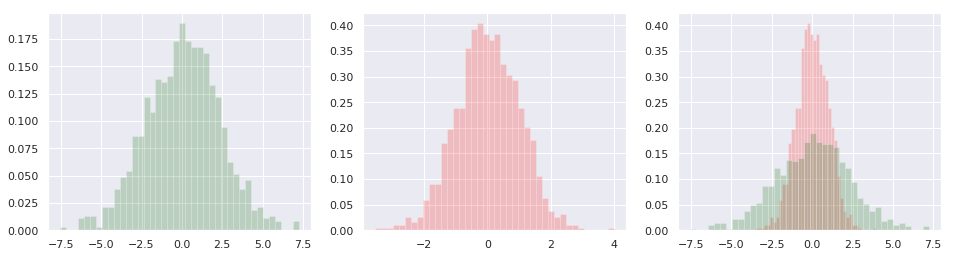

In [15]:
n_samples = 1000
generated_true_x = toynn.generate_from_decoder(decoder_true, n_samples)
generated_x = toynn.generate_from_decoder(decoder, n_samples)

# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

ax = axes[1]
toyvis.plot_data(generated_x, color='red', ax=ax)

ax = axes[2]
toyvis.plot_data(generated_x, color='red', ax=ax)
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

# Inspect results from VEM

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[1.9226]], device='cuda:0') 



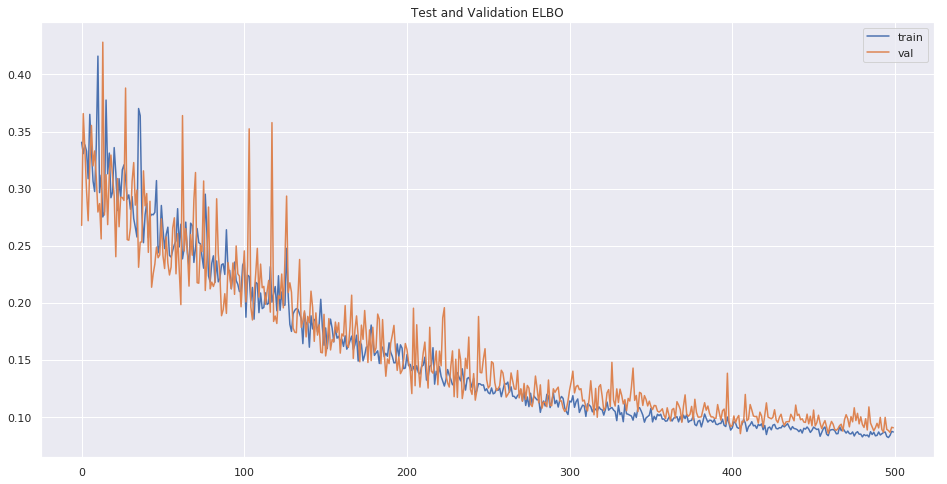

In [16]:
decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)

decoder_path = glob.glob(f'{OUTPUT}/train_vem/models/decoder.pth')[0]
decoder = torch.load(decoder_path, map_location=DEVICE)

print('-- True values of parameters')
for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')

print('\n-- Learnt values of parameters')
for name, param in decoder.named_parameters():
    print(name, param.data, '\n')
    
train_losses_path = glob.glob(f'{OUTPUT}/train_vem/train_losses.pkl')[0]
train_losses_all_epochs = pickle.load(open(train_losses_path, 'rb'))

val_losses_path = glob.glob(f'{OUTPUT}/train_vem/val_losses.pkl')[0]
val_losses_all_epochs = pickle.load(open(val_losses_path, 'rb'))

train_losses_total = [loss['total'] for loss in train_losses_all_epochs]
val_losses_total = [loss['total'] for loss in val_losses_all_epochs]
n_epochs = len(train_losses_total)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

ax.plot(range(n_epochs), train_losses_total, label='train')
ax.plot(range(n_epochs), val_losses_total, label='val')
ax.set_title('Test and Validation ELBO')
ax.legend()

#print('Last losses:')
#print(train_losses_total[-5:]#)

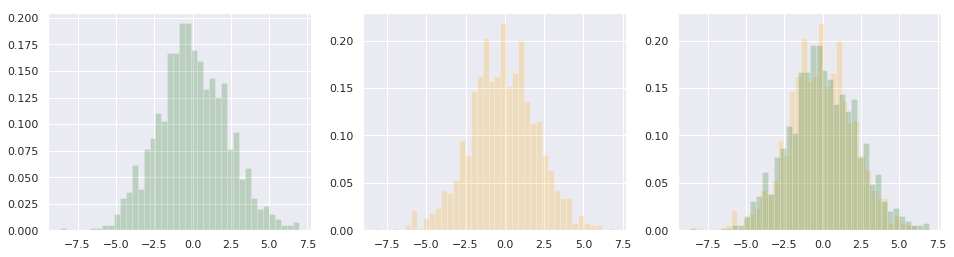

In [17]:
n_samples = 1000
generated_true_x = toynn.generate_from_decoder(decoder_true, n_samples)
generated_x = toynn.generate_from_decoder(decoder, n_samples)

# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)


ax = axes[1]
toyvis.plot_data(generated_x, color='orange', ax=ax)


ax = axes[2]
toyvis.plot_data(generated_x, color='orange', ax=ax)
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

# Print pipeline logs

In [37]:
pattern = 'logs'
logs = []
for filename in os.listdir(OUTPUT):
    if re.search(pattern, filename):
        logs.append(filename)

print('Found %d log files.' % len(logs))
        
for filename in logs:
    path = os.path.join(OUTPUT, filename)
    print('\n-- Log file: %s\n' % filename)
    with open(path, 'r') as f:
        message = f.read()
    print(message)

Found 1 log files.

-- Log file: logs2019-05-11 20:36:40.619998.txt

2019-05-11 20:36:40,620 root         INFO     start
2019-05-11 20:36:40,634 luigi        INFO     logging configured by default settings
2019-05-11 20:36:40,659 luigi-interface DEBUG    Checking if RunAll() is complete
2019-05-11 20:36:40,660 luigi-interface DEBUG    Checking if TrainVAE() is complete
2019-05-11 20:36:40,660 luigi-interface DEBUG    Checking if TrainVEM() is complete
2019-05-11 20:36:40,661 luigi-interface INFO     Informed scheduler that task   RunAll__99914b932b   has status   PENDING
2019-05-11 20:36:40,661 luigi-interface DEBUG    Checking if MakeDataSet() is complete
2019-05-11 20:36:40,662 luigi-interface INFO     Informed scheduler that task   TrainVEM__99914b932b   has status   PENDING
2019-05-11 20:36:40,662 luigi-interface INFO     Informed scheduler that task   MakeDataSet__99914b932b   has status   PENDING
2019-05-11 20:36:40,662 luigi-interface INFO     Informed scheduler that task   Trai